1.) Implement a function sigmoid(x) and a function sigmoidprime(x)

In [ ]:
import numpy as np

In [ ]:
# sigmoid(x) function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# sigmoidprime(x) function = derivate of sigmoid(x)
def sigmoidprime(x):
    return sigmoid(x) * (1 - sigmoid(x))


2.) Define the possible inputs and the labels (targets) for and, or, nand, nor and xor

In [ ]:
# inputs consists of each combination of 2^2 (two inputs with two values [true = 1, false = 0])
# all data is converted into numpy array for easier computation
inputs = np.array([[0,0],[0,1],[1,0],[1,1]])

# the labels/targets maps to the input pairs 
# e.g for the logical and operator: [0,0] = 0, [0,1] = 0, [1,0] = 0, [1,1] = 1
t_and = np.array([0,0,0,1])
t_or = np.array([0,1,1,1])
t_nand = np.array([1,1,1,0])
t_nor = np.array([1,0,0,0])
t_xor = np.array([0,1,1,0])

3.) Define a perceptron

In [ ]:
class Perceptron():
    """
    Perceptron class
    
    Represents a single Perceptron with input units, weights and bias
    """
    
    #constructor
    def __init__(self, n_input_units):
        """
        Constructor for instantiating 
        
        :param n_input_units: number of input units
        :type n_input_units: int
        """
        # save input_units as instance variables
        self.n_input_units = n_input_units
        # learning rate
        self.alpha = 1.0
        # random initialization of weights and bias
        self.weights = np.random.randn(self.n_input_units)
        self.bias = np.random.randn(1)
        # initializing drive instance variable, later used in the backpropagation
        self.drive = 0
        self.inputs = []
        
    def forward_step(self, inputs):
        """
        Forward step function for one forward step for THIS Perceptron
        
        :param inputs: input vector
        :param type: numpy float array
        """
        # alternative: drive = np.dot(self.weights, self.inputs) + self.bias
        # calculate drive based on weight matrix and input vector + bias
        drive = self.weights @ inputs + self.bias
        # save drive and input of previous layer for backpropagation
        self.drive = drive
        self.inputs = inputs
        # return with sigmoid activation function
        return sigmoid(drive)
    
    def update(self, delta):
        """
        Update function used in backpropagation to update the weights and biases
        
        :param delta: error score calculated for the following layer N+1
        :param type: float 
        """
        # update the weights and bias based on the learning rate and the calculated delta of according MLP
        # calculate gradient p_deriv
        p_deriv = delta * self.inputs
        # adjust weight with gradients and lerning rate alpha
        self.weights = self.weights - self.alpha * p_deriv
        # for bias there´s is no explicit input unit, so we can use 1 here (calculated with the respective error score)
        self.bias = self.bias - self.alpha * (delta * 1)

4.) Define MLP class with one hidden layer (4 perceptrons) and one output perceptron

In [ ]:
class MLP():
    """
    Multi Layer Perceptron class
    
    MLP consisting of:
    1 input layer: 2 Inputs
    1 hidden layer: 4 Perceptrons with 2 inputs
    1 output layer: 1 Perceptron with 4 inputs
    """
    
    def __init__(self):
        """
        Constructor 
        
        Initialize MLP
        """
        # initialize hidden layer with 4 Perceptron with 2 inputs each
        self.hiddenLayer = np.array([
            Perceptron(2),
            Perceptron(2),
            Perceptron(2),
            Perceptron(2)
        ])
        # initialize output Perceptron taking 4 inputs (from the 4 perceptrons of the hidden layer)
        self.output = Perceptron(4)
        
    def forward_step(self, inputs):
        """
        Perform one forward step for the WHOLE MLP
        
        :param inputs: input vector 
        :param type: numpy float array
        """
        # initialize numpy 4-element-vector for storing the output of each of the 4 Perceptron of the hiddenlayer
        outputHiddenLayer = np.zeros(shape=(4))
        # perform the forward step for all 4 perceptrons of the hidden layer and store the output 
        for i in range(len(self.hiddenLayer)):
            outputHiddenLayer[i] = self.hiddenLayer[i].forward_step(inputs)
        # perform the forward step for the output perceptron with the output of the hidden layer as input
        output = self.output.forward_step(outputHiddenLayer)
        # return the result of the output perceptron (essentially of the whole MLP)
        # output already has the sigmoid activation function applied
        return output
            
    def backprop_step(self, target, prediction):
        """
        Function for doing ONE backpropagation step for the whole MLP 
        
        :param target: label of the dataset (the expected output for the recent input from the forward step)
        :param type: int (0 or 1)
        
        :param prediction: predicted output of the MLP
        :param type: float (between 0 and 1)
        """
        error_term = 0
        # Saving the old weights of the output perceptron (output layer)
        old_output_weights = self.output.weights
        # Perform backpropagation for whole MLP (2 layers)
        for i in range(2):
            # First time: Output Layer
            if(i == 0):
                # 1.) calculated error
                error_term =  - (target - prediction) * sigmoidprime(self.output.drive)
                # 2.)adjust weights & bias of output perceptron
                self.output.update(error_term)            
            else:
                # Second time: Hidden Layer (we only have one)
                # Go through all Perceptrons of the one hidden layer
                for j in range(len(self.hiddenLayer)): 
                    # Since there´s only one output neuron, there´s only a single sum for the error score
                    # + we use the old weights from the output neuron here and not the updated ones
                    # sigmoidprime is the derivative of sigmoid 
                    tmp_error_term = (error_term * old_output_weights[j]) * sigmoidprime(self.hiddenLayer[j].drive)
                    # Update weights and bias for each Perceptron of the hidden layer
                    self.hiddenLayer[j].update(tmp_error_term)

5. & 6.) Training and Visualization 

In [ ]:
"""
Simple function to train each logical operator once

:param training_labels: labels of the respective training set (and, or, ...)
:param type: int numpty array (0 or 1)

:param log_op: name of logical operator
:param type: string
"""
def train_logical_op(training_labels, log_op):
    # Instantiate MLP
    mlp = MLP()
    
    # Set training labels
    t = training_labels
    
    # Variables recorded for plotting
    epochs = []
    accuracies = []
    avg_losses = []

    # Train 1000 epochs
    for i in range(1000):
        epochs.append(i)

        accuracy_sum = 0
        avg_loss_sum = 0
        
        # Each epoch draws each data point [0,0],[1,0],[0,1],[1,1] once
        for j in range(len(inputs)):
            sample = inputs[j]
            target = t[j]

            # Get prediction of whole MLP for given input (sample)
            prediction = mlp.forward_step(sample)

            # Record squared error for plotting
            squared_error = np.power(target - prediction, 2)
            avg_loss_sum += squared_error

            # Perform a backprop step
            mlp.backprop_step(target, prediction)

            # Record accuracy (prediction is right for 1 when prediction >= 0.5 and vice versa)
            if(prediction >= 0.5 and target == 1 or prediction < 0.5 and target == 0):
                accuracy_sum += 1

        # Calculate average loss and accuracy
        avg_loss = avg_loss_sum /4
        avg_losses.append(avg_loss)

        accuracy = accuracy_sum / 4
        accuracies.append(accuracy)
    
    # Import plotting library
    import matplotlib.pyplot as plt
    
    # Plotting first figure for accuracy
    figure1 = plt.figure()
    plt.plot(epochs, accuracies)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim([-0.1, 1.2])
    figure1.suptitle("["+ log_op + "] Accuracy")
    plt.show()

    # Plotting second figure for average loss 
    figure2 = plt.figure()
    plt.plot(epochs, avg_losses)
    plt.xlabel("Epochs")
    plt.ylabel("Average Loss")
    plt.ylim([-0.1, 1.2])
    figure2.suptitle("[" + log_op + "] Average Loss")
    plt.show()
        


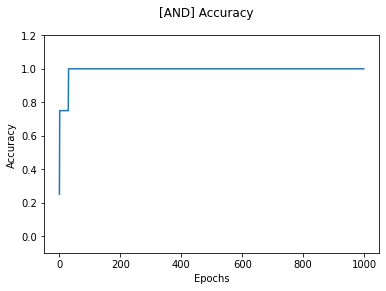

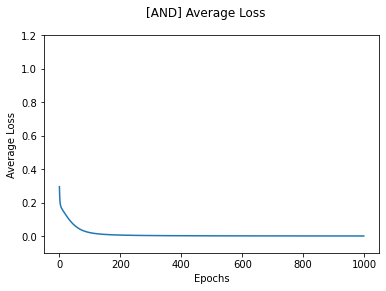

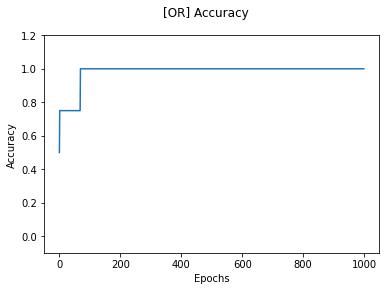

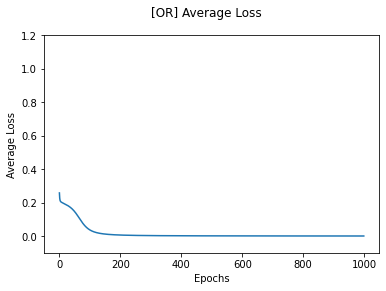

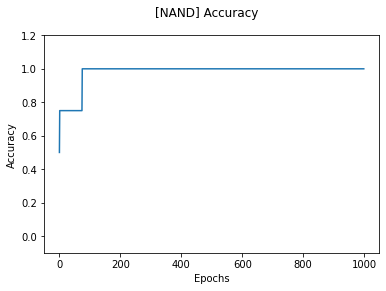

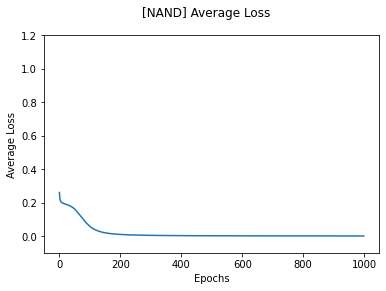

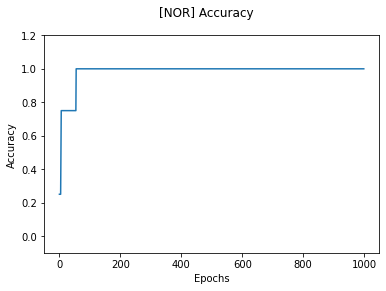

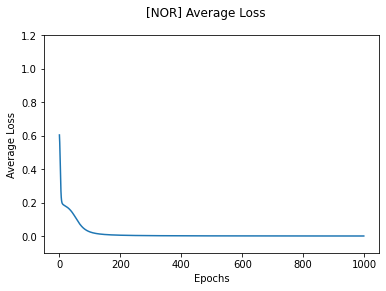

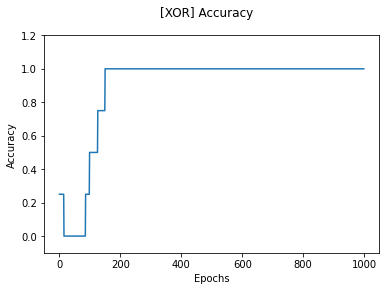

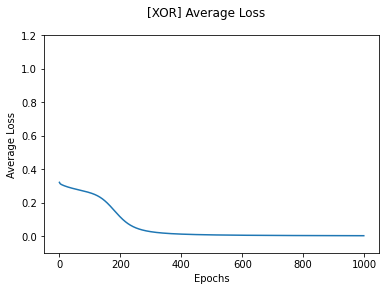

In [ ]:
# Train each logical operator once and show results (plots)
train_logical_op(t_and,"AND")
train_logical_op(t_or,"OR")
train_logical_op(t_nand,"NAND")
train_logical_op(t_nor,"NOR")
train_logical_op(t_xor,"XOR")